# Домашнее задание

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

In [18]:
max_words = 3000
max_len = 10
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [19]:
import pandas as pd

# Загрузка данных
df_train = pd.read_csv('train.csv', encoding='latin-1')
df_val = pd.read_csv('test.csv', encoding='latin-1')

In [20]:
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


0 - negative<br>
1 - positive

In [21]:
df_train['label'].value_counts().sum()

31962

In [22]:
df_val.tail()

,id,tweet
17192,49155,thought factory: left-right polarisation! #tru...
17193,49156,feeling like a mermaid Ã°ÂÂÂ #hairflip #nev...
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...
17195,49158,"happy, at work conference: right mindset leads..."
17196,49159,"my song ""so glad"" free download! #shoegaze ..."


In [23]:
missing_data = df_train['label'].isnull().sum()
print("Количество отсутствующих значений в столбце 'label':", missing_data)

Количество отсутствующих значений в столбце 'label': 0


### Предобработка

In [24]:
# !pip install nltk

In [25]:
# !pip install spacy && python -m spacy download en_core_web_sm

In [26]:
from string import punctuation
import spacy
import re

In [27]:
puncts = set(punctuation)

**ПОЗАВТРАКАЛИ**

Стемминг (убираем лишнии куски слова):
**завтрак**<br>
Очень быстро, очень дешево и очень слабо.

spaCy не имеет инструмента для стемминга, поскольку в нём отдаётся предпочтение лемматизации

Лемматизация (перевод в неопределенную форму для гл. и в им.падеж для сущ.):
**позавтракать**<br>
Небыстро, сложно.

In [28]:
nlp = spacy.load('en_core_web_sm')

stop_words = nlp.Defaults.stop_words # Загрузка списка стоп-слов

In [29]:
def preprocess_text(txt):
    txt = str(txt)
#     txt = re.sub(r"'t\s", " not", txt) # Функция re.sub заменяет "'t__" на " not" без пробела.   
#     txt = re.sub(r"(\bnot\b)", "\bnot", txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    
    txt = ' '.join([word for word in txt.split() if word.lower() not in stop_words]) # Удаление стоп-слов
    txt = [token.lemma_ for token in nlp(txt)] # Лемматизация слов
    
    return " ".join(txt)

In [30]:
df_train['tweet'].iloc[:2].values

array([' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run',
       "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"],
      dtype=object)

In [31]:
df_train['tweet'].iloc[:2].apply(preprocess_text).values

array(['user father dysfunctional selfish drag kid dysfunction run',
       'user user thank lyft credit can not use cause do not offer wheelchair van pdx disapointe getthanke'],
      dtype=object)

In [32]:
from tqdm import tqdm 
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|████████████████████████████████████| 17197/17197 [01:00<00:00, 285.28it/s]


In [33]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [34]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to /Users/annvorosh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['user', 'father', 'dysfunctional', 'selfish', 'drag']

Отфильтруем данные

и соберём в корпус N наиболее частых токенов

In [35]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [36]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2999

In [37]:
tokens_filtered_top[:10]

['user', 'ã', 'love', 'day', 'not', 'happy', 'amp', 'i', 'good', 'm']

In [38]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
vocabulary

{'user': 1,
 'ã': 2,
 'love': 3,
 'day': 4,
 'not': 5,
 'happy': 6,
 'amp': 7,
 'i': 8,
 'good': 9,
 'm': 10,
 'time': 11,
 'life': 12,
 'u': 13,
 'like': 14,
 'today': 15,
 'do': 16,
 'new': 17,
 'positive': 18,
 'thankful': 19,
 'father': 20,
 'people': 21,
 'go': 22,
 'smile': 23,
 'bihday': 24,
 'can': 25,
 'get': 26,
 's': 27,
 'want': 28,
 'work': 29,
 'come': 30,
 'look': 31,
 'feel': 32,
 'friend': 33,
 'need': 34,
 'wait': 35,
 'weekend': 36,
 'healthy': 37,
 'girl': 38,
 'thank': 39,
 'family': 40,
 'think': 41,
 'week': 42,
 'fun': 43,
 'way': 44,
 'know': 45,
 'find': 46,
 'great': 47,
 'summer': 48,
 'you': 49,
 'friday': 50,
 'live': 51,
 '2': 52,
 'bull': 53,
 'year': 54,
 'beautiful': 55,
 'thing': 56,
 'morning': 57,
 'music': 58,
 'watch': 59,
 'world': 60,
 'home': 61,
 'tomorrow': 62,
 'make': 63,
 'affirmation': 64,
 'fathersday': 65,
 'sad': 66,
 'dad': 67,
 'cute': 68,
 'orlando': 69,
 're': 70,
 'right': 71,
 'blog': 72,
 'night': 73,
 'model': 74,
 'happiness':

In [39]:
import numpy as np


def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [40]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_train, test_size=0.2, random_state=42)

In [41]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["tweet"]])

CPU times: user 2.02 s, sys: 9.27 ms, total: 2.02 s
Wall time: 2.02 s


In [42]:
x_train.shape

(25569, 10)

In [43]:
df_train['tweet'].iloc[10]

'user user user way youngsweet fellaindias friend ã ° â\x9fâ\x98â\x9e'

In [44]:
x_train[2]

array([  50,    2,    2,   50,   93, 1766,  394,    0,    0,    0])

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [46]:
from torch.utils.data import DataLoader, Dataset


class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [47]:
from torch.utils.data import WeightedRandomSampler

# получаем балансировку весов для каждого класса
class_counts = np.bincount(df_train['label'])
class_weights = 1.0 / class_counts

# создаем взвешенный сэмплер
weights = [class_weights[label] for label in df_train['label']]
sampler = WeightedRandomSampler(weights, len(df_train))

# создаем DataLoader с использованием взвешенного сэмплера
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [48]:
# Получаем балансировку весов для каждого класса в валидационном наборе данных
class_counts_test = np.bincount(df_test['label'])
class_weights_test = 1.0 / class_counts_test

# Создаем взвешенный сэмплер для валидационного набора данных
weights_test = [class_weights_test[label] for label in df_test['label']]
sampler_test = WeightedRandomSampler(weights_test, len(df_test))

# Создаем DataLoader с использованием взвешенного сэмплера для валидационного набора данных
test_dataset = DataWrapper(x_test, df_test['label'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [49]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 10])
torch.Size([512])
tensor(0)


In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### LSTM

In [51]:
from torch import nn


class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [52]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [53]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(3000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 399381


In [54]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(test_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/20]. Step [50/50]. Loss: 0.406. Acc: 0.930. Test loss: 0.377. Test acc: 0.929
Epoch [2/20]. Step [50/50]. Loss: 0.266. Acc: 0.930. Test loss: 0.298. Test acc: 0.929
Epoch [3/20]. Step [50/50]. Loss: 0.197. Acc: 0.930. Test loss: 0.189. Test acc: 0.929
Epoch [4/20]. Step [50/50]. Loss: 0.179. Acc: 0.932. Test loss: 0.191. Test acc: 0.935
Epoch [5/20]. Step [50/50]. Loss: 0.135. Acc: 0.940. Test loss: 0.170. Test acc: 0.941
Epoch [6/20]. Step [50/50]. Loss: 0.143. Acc: 0.948. Test loss: 0.151. Test acc: 0.947
Epoch [7/20]. Step [50/50]. Loss: 0.126. Acc: 0.952. Test loss: 0.256. Test acc: 0.947
Epoch [8/20]. Step [50/50]. Loss: 0.122. Acc: 0.956. Test loss: 0.111. Test acc: 0.949
Epoch [9/20]. Step [50/50]. Loss: 0.142. Acc: 0.959. Test loss: 0.190. Test acc: 0.950
Epoch [10/20]. Step [50/50]. Loss: 0.121. Acc: 0.962. Test loss: 0.115. Test acc: 0.949
Epoch [11/20]. Step [50/50]. Loss: 0.099. Acc: 0.963. Test loss: 0.163. Test acc: 0.951
Epoch [12/20]. Step [50/50]. Loss: 0.070.

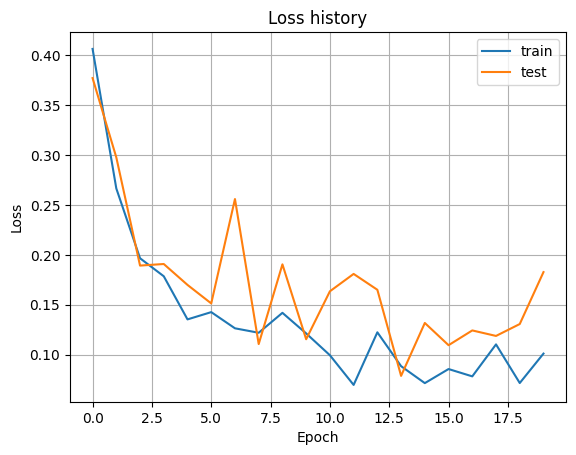

In [55]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

### GRU

In [56]:
from torch import nn


class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [57]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [58]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(3000, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 395541


In [59]:
gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs): 
    gru_init.train() 
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    gru_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(test_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
            
print('Training is finished!')

Epoch [1/20]. Step [50/50]. Loss: 0.312. Acc: 0.899. Test loss: 0.293. Test acc: 0.929
Epoch [2/20]. Step [50/50]. Loss: 0.279. Acc: 0.930. Test loss: 0.258. Test acc: 0.930
Epoch [3/20]. Step [50/50]. Loss: 0.200. Acc: 0.935. Test loss: 0.247. Test acc: 0.938
Epoch [4/20]. Step [50/50]. Loss: 0.174. Acc: 0.942. Test loss: 0.175. Test acc: 0.944
Epoch [5/20]. Step [50/50]. Loss: 0.151. Acc: 0.948. Test loss: 0.115. Test acc: 0.947
Epoch [6/20]. Step [50/50]. Loss: 0.152. Acc: 0.952. Test loss: 0.187. Test acc: 0.949
Epoch [7/20]. Step [50/50]. Loss: 0.155. Acc: 0.956. Test loss: 0.143. Test acc: 0.950
Epoch [8/20]. Step [50/50]. Loss: 0.095. Acc: 0.959. Test loss: 0.073. Test acc: 0.952
Epoch [9/20]. Step [50/50]. Loss: 0.106. Acc: 0.961. Test loss: 0.136. Test acc: 0.952
Epoch [10/20]. Step [50/50]. Loss: 0.107. Acc: 0.962. Test loss: 0.185. Test acc: 0.954
Epoch [11/20]. Step [50/50]. Loss: 0.125. Acc: 0.964. Test loss: 0.195. Test acc: 0.954
Epoch [12/20]. Step [50/50]. Loss: 0.107.

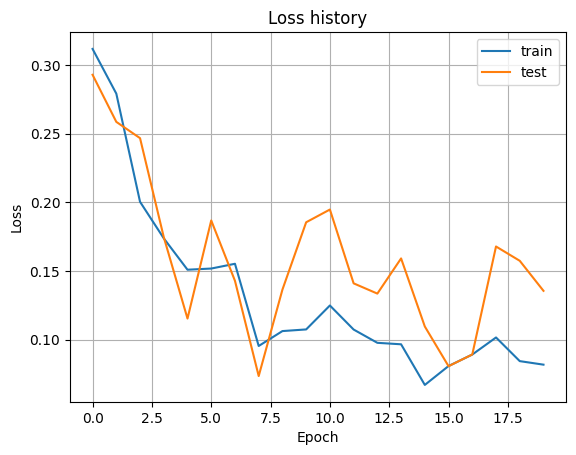

In [60]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend()

### LSTM bidirectional

In [66]:
from torch import nn
    
class LSTMFixedLen(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(hidden_dim * 2, 1)  # Удваиваем размерность скрытого слоя из-за двунаправленности
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, (ht, _) = self.lstm(x)

        if self.use_last:
            last_tensor = torch.cat((ht[-2, :, :], ht[-1, :, :]), dim=1)  # Конкатенируем два последних скрытых состояния
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:, :, :], dim=1)

        out = self.linear(last_tensor)
        return torch.sigmoid(out)


In [67]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [68]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(3000, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 417961


In [69]:
lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    lstm_init.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(test_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

Epoch [1/20]. Step [50/50]. Loss: 0.212. Acc: 0.744. Test loss: 0.281. Test acc: 0.929
Epoch [2/20]. Step [50/50]. Loss: 0.316. Acc: 0.930. Test loss: 0.263. Test acc: 0.929
Epoch [3/20]. Step [50/50]. Loss: 0.191. Acc: 0.931. Test loss: 0.132. Test acc: 0.935
Epoch [4/20]. Step [50/50]. Loss: 0.129. Acc: 0.939. Test loss: 0.155. Test acc: 0.943
Epoch [5/20]. Step [50/50]. Loss: 0.115. Acc: 0.947. Test loss: 0.134. Test acc: 0.949
Epoch [6/20]. Step [50/50]. Loss: 0.110. Acc: 0.953. Test loss: 0.151. Test acc: 0.952
Epoch [7/20]. Step [50/50]. Loss: 0.128. Acc: 0.957. Test loss: 0.194. Test acc: 0.953
Epoch [8/20]. Step [50/50]. Loss: 0.094. Acc: 0.962. Test loss: 0.176. Test acc: 0.953
Epoch [9/20]. Step [50/50]. Loss: 0.111. Acc: 0.964. Test loss: 0.166. Test acc: 0.952
Epoch [10/20]. Step [50/50]. Loss: 0.086. Acc: 0.965. Test loss: 0.176. Test acc: 0.956
Epoch [11/20]. Step [50/50]. Loss: 0.084. Acc: 0.969. Test loss: 0.147. Test acc: 0.956
Epoch [12/20]. Step [50/50]. Loss: 0.079.

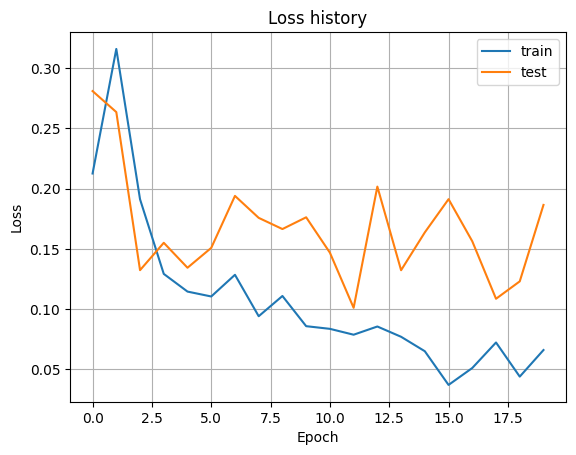

In [70]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

### ВЫВОДЫ:

#### для улучшения результата попробовали внести двунаправленность в сеть LSTM, но качество сети от этого не сильно изменилось

#### для улучшения результата увеличели количество топовых слов с 2000 до 3000, при этом сократили длину сообщения с 20 до 10 слов. Поработали над балансировкой классов, так как наблюдался большой дисбаланс, подавая взвешенный сэмплер для каждого валидационного набора данных